In [135]:
import json
import math
import base64
from datetime import datetime
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from celluloid import Camera
from IPython.display import Image
from IPython.display import HTML

BAYES_QUARTILE_OPT = 0.25
RATES = [1,2,3,4,5]
colorsList = ["red", "orange", "green"]
colors = ListedColormap(colorsList)
CRITERIAS = ["Nb rating", "Average Rating", "Bayes Rating", "Median", "STD", "Depreciation", "Neutral", "Appreciations"]

def loadData(nbChunks = 0):  # <= 0 to load all chunks, positive integer to load specific number of chunks
    asinToIndex = {}
    scoreMatrix = []
    booksAsin = []
    index = 0
    chunks = pd.read_json(
        '../Dataset/Books.json', lines=True, chunksize=100000, #500000
        typ="frame", orient="records", dtype={"asin": str, "overall": int, "unixReviewTime": int}
    )
    for chunk in chunks:
        for _, item in chunk.iterrows():
            asin = item["asin"]
            rate = item["overall"]
            if (asin not in asinToIndex):
                scoreMatrix.append([0,0,0,0,0])
                booksAsin.append(asin)
                asinToIndex[asin] = index
                index += 1
            row = asinToIndex[asin]
            scoreMatrix[row][rate-1] += 1
        nbChunks -= 1
        if (nbChunks == 0): break
    return scoreMatrix, booksAsin, asinToIndex

def getMedian(scoreMatrix, nbRating):
    def rowMedian(i):
        s = 0
        for k in sorted([0,1,2,3,4]):
            s += scoreMatrix[i,k]
            if s > nbRating[i] / 2:
                break
        return k + 1
    medianMat = np.array([ rowMedian(i) for i in range(0, nbRating.size) ])
    return medianMat

def getBookStats(scoreMatrix, booksAsin):
    nbRating = np.sum(scoreMatrix, axis=1)
    avgRatings = (np.average(scoreMatrix, axis=1, weights=RATES) * np.sum(RATES)) / nbRating
    medianMat = getMedian(scoreMatrix, nbRating)
    stdRatings = np.std(scoreMatrix, axis=1)
    confidenceNumber = np.quantile(nbRating, BAYES_QUARTILE_OPT)
    arithAverage = np.mean(avgRatings)
    bayesAvgRatings = (nbRating * avgRatings + arithAverage * confidenceNumber) / (nbRating + confidenceNumber)
    nbNonAppreciate = scoreMatrix[:,0]+scoreMatrix[:,1]
    nbNeutral = scoreMatrix[:,2]
    nbAppreciate = scoreMatrix[:,3]+scoreMatrix[:,4]
    realClass = np.argmax(np.column_stack((nbNonAppreciate, nbNeutral, nbAppreciate)), axis=1).astype(int)
    return pd.DataFrame(
        data=np.column_stack((nbRating, avgRatings, bayesAvgRatings, medianMat, stdRatings, nbNonAppreciate, nbNeutral, nbAppreciate, realClass)),
        index=booksAsin, 
        columns=["Nb rating", "Average Rating", "Bayes Rating", "Median", "STD", "Depreciation", "Neutral", "Appreciations", "Class"]
    )


scoreMatrix, booksAsin, asinToIndex = loadData(1)
scoreMatrix = np.array(scoreMatrix)
pdScoreMat = pd.DataFrame(
    data=scoreMatrix,
    index=booksAsin,
    columns=[f"{i} ⭐" for i in RATES]
)
display(pdScoreMat)

pdBooksFeatures = getBookStats(scoreMatrix, booksAsin)
display(pdBooksFeatures)
count = [ (pdBooksFeatures.Class.values == i).sum() for i in range(0, 3) ]
for i in range(0,3):
    nbStars = (i+1) * "⭐"
    print(f"{nbStars} : {count[i]} samples")

,1 ⭐,2 ⭐,3 ⭐,4 ⭐,5 ⭐
000100039X,6,4,8,15,173
0001055178,0,4,2,10,2
0001473123,1,0,0,2,13
0001473727,0,0,0,0,7
0001473905,0,0,1,0,5
...,...,...,...,...,...
0060534095,0,0,0,1,4
0060534214,5,5,4,19,22
0060534249,2,2,5,12,17
0060534389,1,3,9,30,23


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,Class
000100039X,206.0,4.674757,4.659002,5.0,66.004242,10.0,8.0,188.0,2.0
0001055178,18.0,3.555556,3.734699,4.0,3.440930,4.0,2.0,12.0,2.0
0001473123,16.0,4.625000,4.494238,5.0,4.955805,1.0,0.0,15.0,2.0
0001473727,7.0,5.000000,4.597677,5.0,2.800000,0.0,0.0,7.0,2.0
0001473905,6.0,4.666667,4.412883,5.0,1.939072,0.0,1.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...
0060534095,5.0,4.800000,4.447290,5.0,1.549193,0.0,0.0,5.0,2.0
0060534214,55.0,3.872727,3.909153,4.0,7.823043,10.0,4.0,41.0,2.0
0060534249,38.0,4.052632,4.074833,4.0,5.953150,4.0,5.0,29.0,2.0
0060534389,66.0,4.075758,4.087226,4.0,11.391225,4.0,9.0,53.0,2.0


⭐ : 83 samples
⭐⭐ : 57 samples
⭐⭐⭐ : 2501 samples


In [136]:
booksFeatures = pdBooksFeatures[CRITERIAS].to_numpy()
NB_CLUSTERS = 3
CLASSES = [f"C{i+1}" for i in range(0, NB_CLUSTERS)]

def kmeansClustering(booksData, distFunc, show=False):
    # As per : https://stackoverflow.com/questions/46409846/using-k-means-with-cosine-similarity-python
    data = preprocessing.normalize(booksData) if distFunc == "cosine" else booksData
    kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1000).fit(data)
    # K means
    if (show):
        print(f"K-means ({distFunc}):")
        display(pd.DataFrame(
            data=np.array([ [f"C{i+1}" for i in kmeans.labels_] ]),
            index=["Class"],
            columns=booksAsin
        ))
        display(pd.DataFrame(
            data=np.array([[np.count_nonzero(kmeans.labels_ == i) for i in range(0, NB_CLUSTERS)]]),
            index=["Number of Classes"],
            columns=CLASSES
        ))
    return kmeans

kmeansEucli, kmeansCos = kmeansClustering(booksFeatures, "euclidean", True), kmeansClustering(booksFeatures, "cosine", True)

K-means (euclidean):


,000100039X,0001055178,0001473123,0001473727,0001473905,0001712772,000171287X,0001714538,0002005395,0002006715,...,0060533226,0060533390,0060533455,0060533994,0060534044,0060534095,0060534214,0060534249,0060534389,0060534397
Class,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,...,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1


,C1,C2,C3
Number of Classes,2612,4,25


K-means (cosine):


,000100039X,0001055178,0001473123,0001473727,0001473905,0001712772,000171287X,0001714538,0002005395,0002006715,...,0060533226,0060533390,0060533455,0060533994,0060534044,0060534095,0060534214,0060534249,0060534389,0060534397
Class,C1,C1,C3,C2,C2,C3,C3,C2,C3,C2,...,C1,C3,C2,C1,C1,C2,C1,C1,C1,C1


,C1,C2,C3
Number of Classes,919,901,821


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations
000100039X,1.063049,0.915953,1.412028,0.736944,1.717776,0.250935,0.202767,1.268369
0001055178,-0.125594,-1.222406,-1.393247,-0.749893,-0.128770,0.007839,-0.113074,-0.143692
0001473123,-0.138240,0.820886,0.911966,0.736944,-0.084059,-0.113708,-0.218354,-0.119623
0001473727,-0.195143,1.537365,1.225905,0.736944,-0.147687,-0.154224,-0.218354,-0.183808
0001473905,-0.201465,0.900495,0.665052,0.736944,-0.173097,-0.154224,-0.165714,-0.199854
...,...,...,...,...,...,...,...,...
0060534095,-0.207788,1.155243,0.769477,0.736944,-0.184605,-0.154224,-0.218354,-0.199854
0060534214,0.108341,-0.616414,-0.863777,-0.749893,0.000567,0.250935,-0.007793,0.088977
0060534249,0.000857,-0.272687,-0.360936,-0.749893,-0.054622,0.007839,0.044847,-0.007300
0060534389,0.177889,-0.228502,-0.323323,-0.749893,0.105881,0.007839,0.255408,0.185254


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Nb rating,0.484469,-0.029300,-0.103282,-0.003300,0.020435,-0.007504,-0.388326,7.761976e-01
Average Rating,-0.018145,-0.583059,0.100174,0.373497,0.097906,0.707323,-0.016976,6.661338e-16
Bayes Rating,-0.019834,-0.582848,0.011913,0.417790,-0.109156,-0.687668,0.020059,-8.619407e-16
Median,-0.003480,-0.546561,0.141233,-0.824350,0.017030,-0.037506,0.007960,1.370432e-16
STD,0.426760,-0.087318,-0.543205,-0.039402,-0.240856,0.086112,0.669478,-3.219647e-15
Depreciation,0.399897,0.082204,0.642553,0.038771,-0.631832,0.055085,0.045049,-1.211269e-01
Neutral,0.452538,0.051096,0.387947,0.054114,0.720323,-0.122030,0.310998,-9.322844e-02
Appreciations,0.466609,-0.061247,-0.317429,-0.020112,0.041261,-0.001831,-0.549090,-6.116813e-01


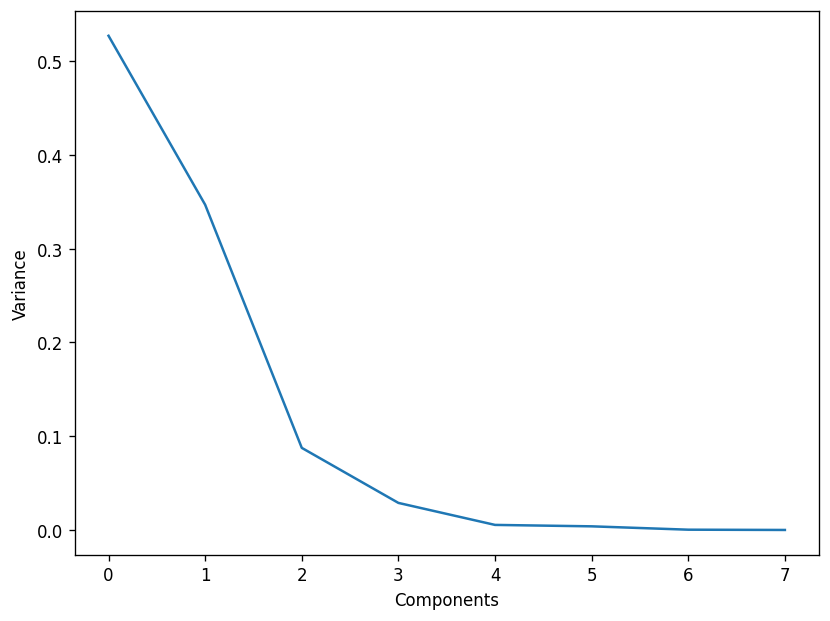

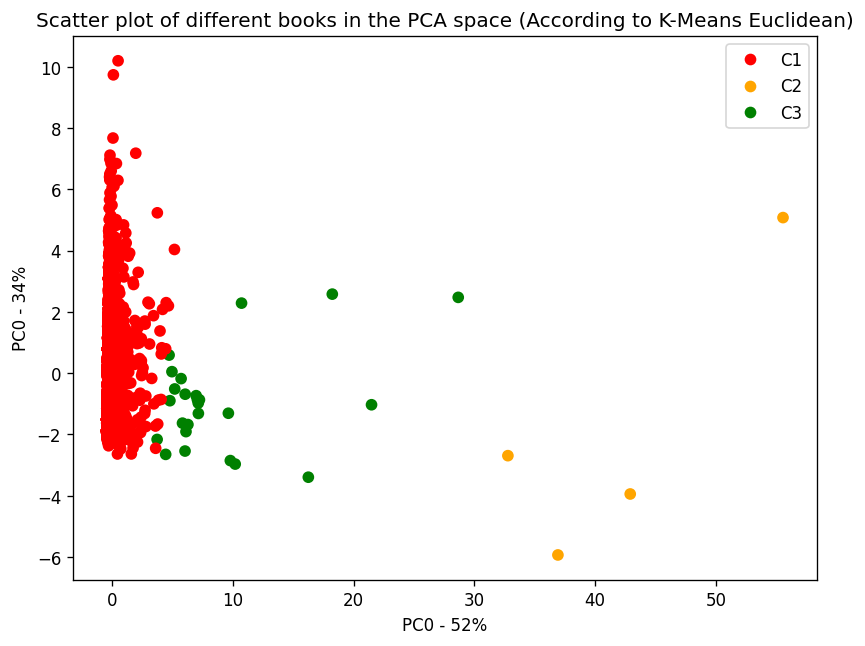

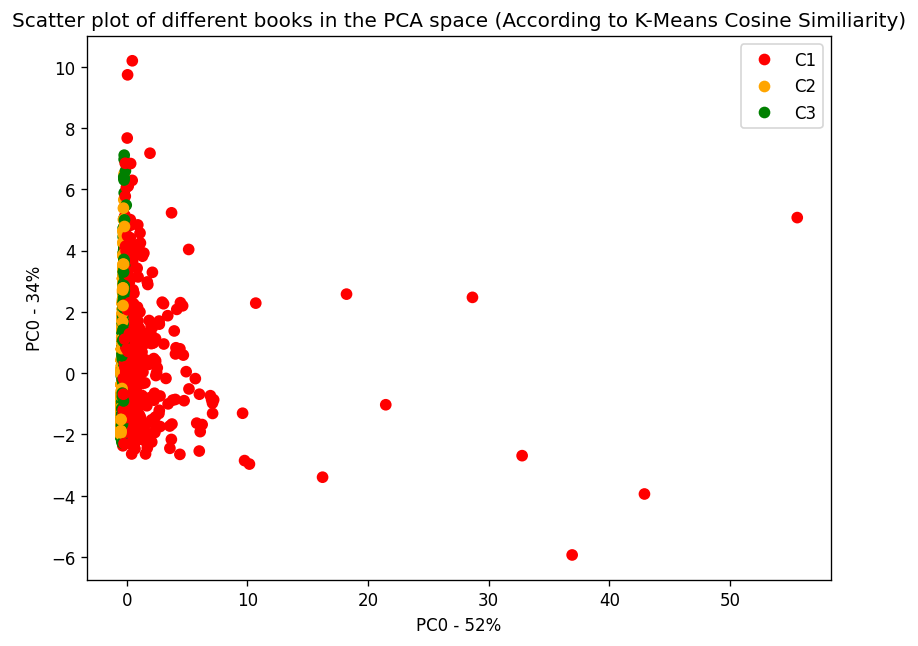

In [137]:
def calculatePCA(pdBooks):
    # Data Normalization
    pdBooksFeaturesNormalized = (pdBooks[CRITERIAS] - pdBooks[CRITERIAS].mean()) / pdBooks[CRITERIAS].std()
    # PCA Calculations
    pca = PCA(n_components=pdBooksFeaturesNormalized.shape[1])
    pca.fit(pdBooksFeaturesNormalized)
    # PCA Results
    booksFeaturesPCA = pd.DataFrame(
        data=pca.components_.T,
        columns=[f"PC{i}" for i in range(len(pdBooksFeaturesNormalized.columns))],
        index=pdBooksFeaturesNormalized.columns
    )
    return pdBooksFeaturesNormalized, booksFeaturesPCA, pca


pdBooksFeaturesNormalized, booksFeaturesPCA, pca = calculatePCA(pdBooksFeatures)

# Display normalized data 
display(pdBooksFeaturesNormalized)

# Plot all PCA axis and their contributions
display(booksFeaturesPCA)
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(pca.explained_variance_ratio_)
plt.ylabel("Variance")
plt.xlabel("Components")
plt.show()

# Plot PCA (2 major axis)
booksFeatures2PCA = pd.DataFrame(
    data=pca.transform(pdBooksFeaturesNormalized), 
    columns=[f"PC{i}" for i in range(len(pdBooksFeaturesNormalized.columns))]
)

def scatterPlotHelper(dataXY, dataLabels, title="", axisLabel=[]):
    plt.figure(figsize=(8,6), dpi=120)
    if (axisLabel != []):
        plt.xlabel(axisLabel[0])
        plt.ylabel(axisLabel[1])
    scatter = plt.scatter(x=dataXY[0], y=dataXY[1], c=dataLabels, cmap=colors)
    plt.legend(handles=scatter.legend_elements(num=3)[0], labels=CLASSES)
    plt.title(title)
    plt.show()

scatterPlotHelper(
    dataXY=(booksFeatures2PCA["PC0"], booksFeatures2PCA["PC1"]), 
    dataLabels=kmeansEucli.labels_, 
    title="Scatter plot of different books in the PCA space (According to K-Means Euclidean)",
    axisLabel=[f"PC0 - {math.floor(pca.explained_variance_ratio_[0]*100)}%", f"PC0 - {math.floor(pca.explained_variance_ratio_[1]*100)}%"]
)
scatterPlotHelper(
    dataXY=(booksFeatures2PCA["PC0"], booksFeatures2PCA["PC1"]), 
    dataLabels=kmeansCos.labels_, 
    title="Scatter plot of different books in the PCA space (According to K-Means Cosine Similiarity)",
    axisLabel=[f"PC0 - {math.floor(pca.explained_variance_ratio_[0]*100)}%", f"PC0 - {math.floor(pca.explained_variance_ratio_[1]*100)}%"]
)

def displayKmeansClustering(pdBooksFeatures, booksFeatures):
    kmeansEucli, kmeansCos = kmeansClustering(booksFeatures, "euclidean"), kmeansClustering(booksFeatures, "cosine")
    pdBooksFeaturesNormalized, booksFeaturesPCA, pca = calculatePCA(pdBooksFeatures)
    pcaSpace = pca.transform(pdBooksFeaturesNormalized)
    scatterPlotHelper(
        dataXY=(pcaSpace[:,0], pcaSpace[:,1]),
        dataLabels=kmeansEucli.labels_, 
        title="Scatter plot of different books in the PCA space (According to K-Means Euclidean)",
        axisLabel=[f"PC0 - {math.floor(pca.explained_variance_ratio_[0]*100)}%", f"PC1 - {math.floor(pca.explained_variance_ratio_[1]*100)}%"]
    )
    scatterPlotHelper(
        dataXY=(pcaSpace[:,0], pcaSpace[:,1]),
        dataLabels=kmeansCos.labels_, 
        title="Scatter plot of different books in the PCA space (According to K-Means Cosine Similiarity)",
        axisLabel=[f"PC0 - {math.floor(pca.explained_variance_ratio_[0]*100)}%", f"PC1 - {math.floor(pca.explained_variance_ratio_[1]*100)}%"]
    )
    return kmeansEucli, kmeansCos

# Q3 : Interprétation des résultats visuelles
TODO

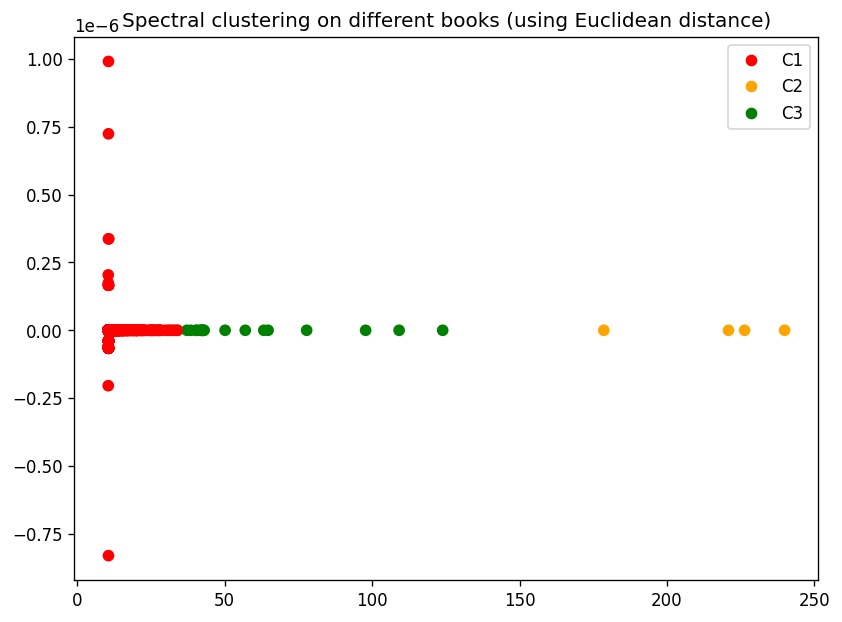

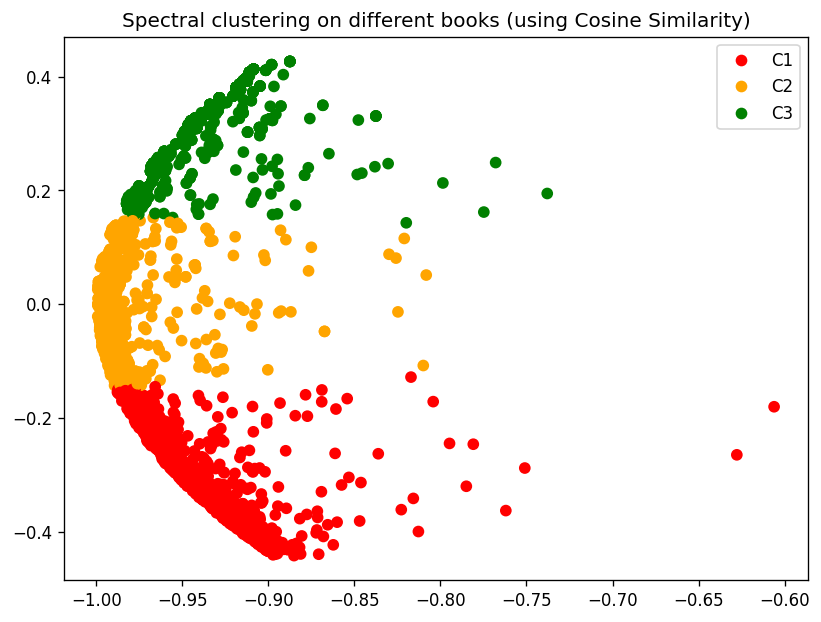

In [138]:
# Q4
def spectralClustering(booksData, distFunc):
    eucli = lambda x, y: np.linalg.norm(x-y)
    cosSim = lambda x, y: (x @ y.T) / (np.linalg.norm(x) * np.linalg.norm(y))
    funcMap = {"euclidean": eucli, "cosine": cosSim}
    N = booksData.shape[0]
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
    M = sp.spatial.distance.squareform(sp.spatial.distance.pdist(np.asarray(booksData), distFunc))
    if (distFunc == "cosine"): M = 1 - M # SciPy uses distance cos which is equal to 1 - sim cos
    eigenValues, eigenVectors = np.linalg.eig(M)
    idx =  eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx].real
    eigenVectors = eigenVectors[:,idx].real
    positiveCount = eigenValues[eigenValues > 0].size
    P = np.stack(eigenVectors[:,0:positiveCount])
    D = np.diag(eigenValues[0:positiveCount])
    spectralDataMat = P @ np.sqrt(D)
    kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1000).fit(spectralDataMat[:,0:2])
    return spectralDataMat[:,0:2], kmeans

def displaySpectralClustering(booksFeatures):
    eucliCoords, spectralEucli = spectralClustering(booksFeatures, "euclidean")
    cosCoords, spectralCos =  spectralClustering(booksFeatures, "cosine")
    scatterPlotHelper(
        dataXY=(eucliCoords[:,0],eucliCoords[:,1]), 
        dataLabels=spectralEucli.labels_, 
        title="Spectral clustering on different books (using Euclidean distance)"
    )
    scatterPlotHelper(
        dataXY=(cosCoords[:,0],cosCoords[:,1]), 
        dataLabels=spectralCos.labels_, 
        title="Spectral clustering on different books (using Cosine Similarity)"
    )
    return eucliCoords, spectralEucli, cosCoords, spectralCos

spectralEucliCoords, spectralEucli, spectralCosCoords, spectralCos = displaySpectralClustering(booksFeatures)

In [139]:
# Q5
def getAccuracyMatrix(pdBooksFeatures, booksFeatures, kmeansEucli, kmeansCos, spectralEucli, spectralCos, spectralEucliCoords, spectralCosCoords):
    bookClasses = pdBooksFeatures[["Class"]].to_numpy(dtype=int).T[0]
    perfMetric = np.array([
        [
            sk.metrics.silhouette_score(booksFeatures, kmeansEucli.labels_), 
            sk.metrics.adjusted_mutual_info_score(kmeansEucli.labels_, bookClasses), 
            sk.metrics.silhouette_score(preprocessing.normalize(booksFeatures), kmeansCos.labels_, metric="cosine"), 
            sk.metrics.adjusted_mutual_info_score(kmeansCos.labels_, bookClasses), 
        ],
        [
            sk.metrics.silhouette_score(spectralEucliCoords, spectralEucli.labels_), 
            sk.metrics.adjusted_mutual_info_score(spectralEucli.labels_, bookClasses), 
            sk.metrics.silhouette_score(spectralCosCoords, spectralCos.labels_, metric="cosine"), 
            sk.metrics.adjusted_mutual_info_score(spectralCos.labels_, bookClasses), 
        ],
    ])
    return perfMetric

def displayAccuracyMatrix(pdBooksFeatures, booksFeatures, kmeansClustering, spectraClustering, spectralEucliCoords, spectralCosCoords):
    accMat = getAccuracyMatrix(pdBooksFeatures, booksFeatures, kmeansClustering[0], kmeansClustering[1], 
        spectraClustering[0], spectraClustering[1], spectralEucliCoords, spectralCosCoords)
    display(pd.DataFrame(
        data=accMat, 
        columns=["Silhouet (Euclidean)", "Mut. Info. (Euclidean)", "Silhouet (Cosine)", "Mut. Info. (Cosine)",],
        index=["K-means", "Spectral"]
    ))
    return accMat

_ = displayAccuracyMatrix(
    pdBooksFeatures, 
    booksFeatures, 
    (kmeansEucli, kmeansCos), 
    (spectralEucli, spectralCos), 
    spectralEucliCoords, 
    spectralCosCoords
)

,Silhouet (Euclidean),Mut. Info. (Euclidean),Silhouet (Cosine),Mut. Info. (Cosine)
K-means,0.945989,-0.000028,0.505294,0.008281
Spectral,0.969018,-0.000806,0.769695,0.008077


b-1) Selon vous quel serait le risque de prendre aléatoirement un sous-ensemble de données pour effectuer les tâches a-1) à a-5) ?

-> Puisque les 3 catégories ne sont pas distrbué d'une maniere uniforme si on prend aléatoirement un sous ensemble de données, on risque d'avoir des catégories qui seront forcément sous représenter voir même pas présent. Par conséquence, notre clustering sera forcément faux car on risque d'appliquer l'algorithme de clustering sur un ensemble de données qui appartient au même groupe (qui n'as pas de sens).

Batch Number 1 Of Book Samples
⭐ : 17 samples
⭐⭐ : 11 samples
⭐⭐⭐ : 500 samples


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,Class
0060512466,8.0,3.000000,3.557832,3.0,1.019804,3.0,3.0,2.0,0.0
0029046564,12.0,2.166667,2.914078,2.0,1.854724,8.0,1.0,3.0,0.0
0060172223,6.0,2.000000,3.182114,1.0,1.469694,4.0,1.0,1.0,0.0
0028636392,39.0,2.769231,2.986250,3.0,6.273755,19.0,4.0,16.0,0.0
0028644913,8.0,2.500000,3.291165,1.0,2.059126,5.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...
0026012502,6.0,4.500000,4.335960,5.0,1.469694,0.0,0.0,6.0,2.0
0060137290,185.0,4.681081,4.663372,5.0,55.248529,5.0,7.0,173.0,2.0
0007112521,15.0,4.066667,4.107613,4.0,2.529822,0.0,4.0,11.0,2.0
0060092165,9.0,4.222222,4.210467,5.0,1.720465,1.0,1.0,7.0,2.0


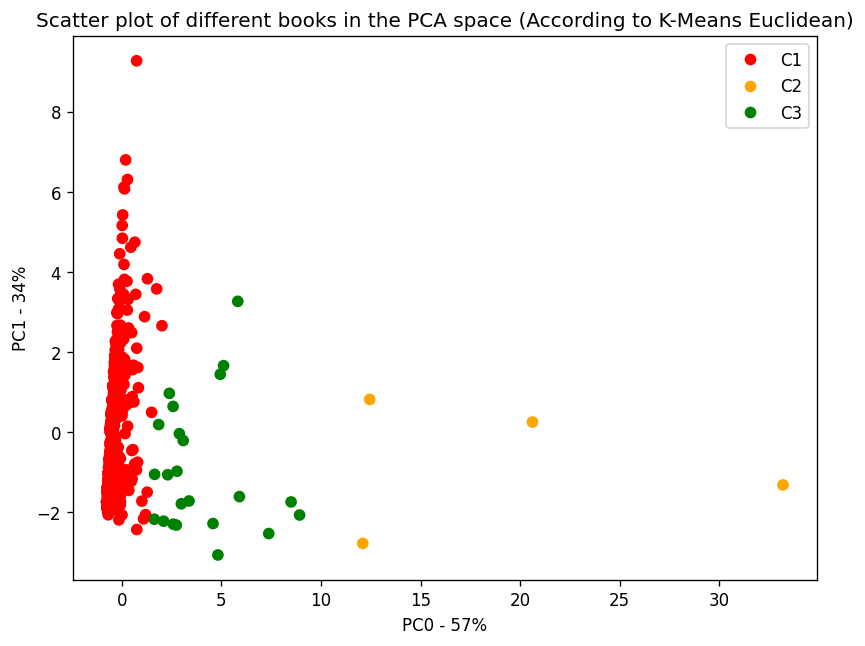

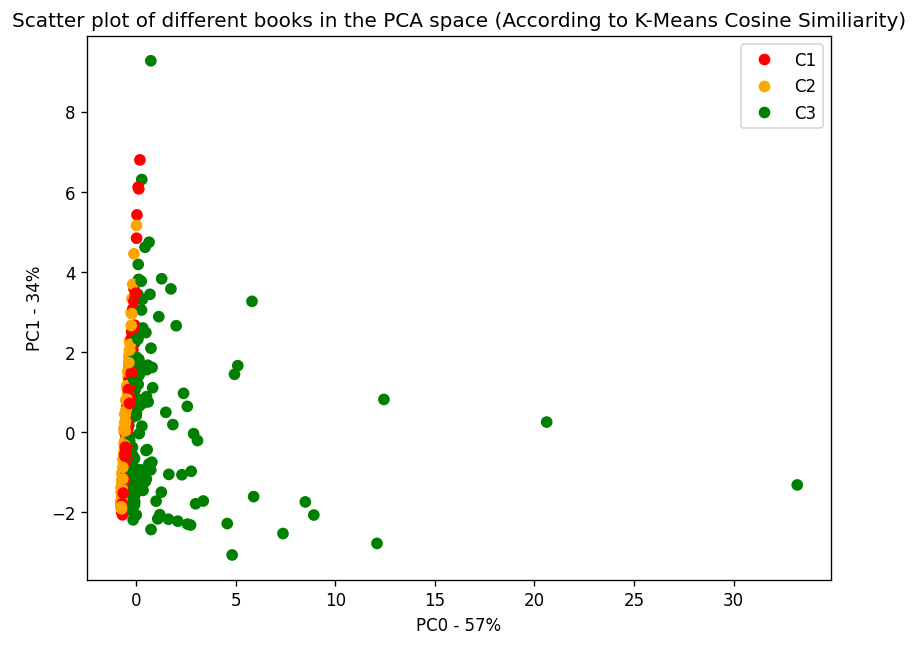

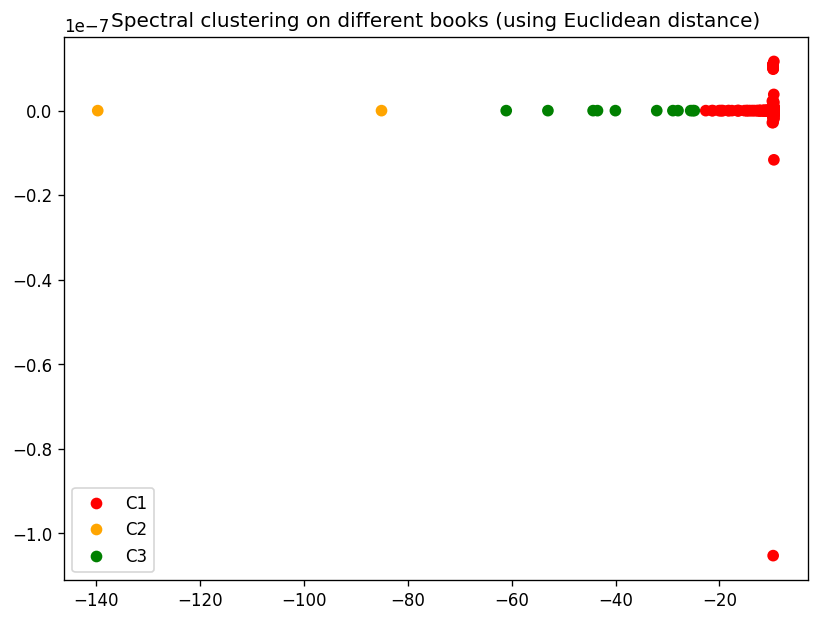

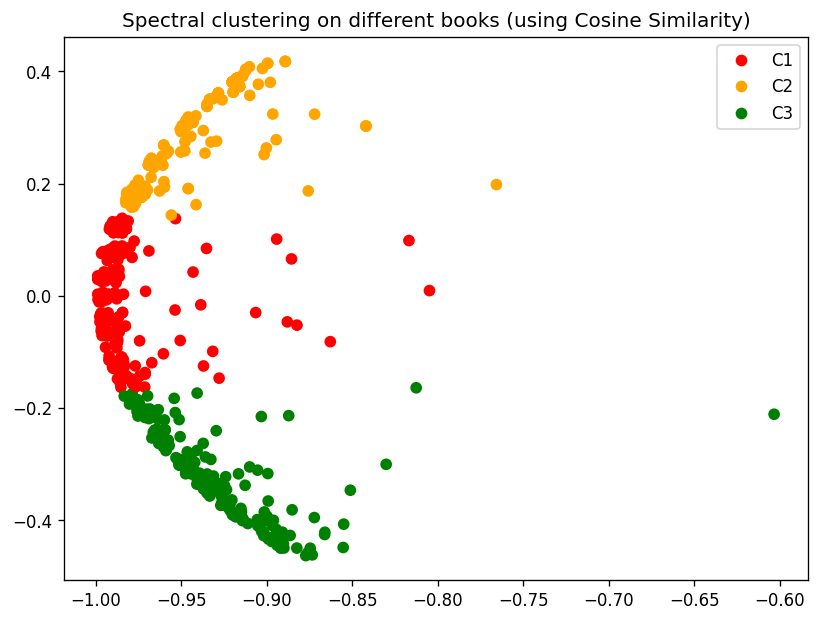

,Silhouet (Euclidean),Mut. Info. (Euclidean),Silhouet (Cosine),Mut. Info. (Cosine)
K-means,0.892883,-0.000713,0.486390,0.007707
Spectral,0.944927,-0.005033,0.755619,0.007305


Batch Number 2 Of Book Samples
⭐ : 17 samples
⭐⭐ : 11 samples
⭐⭐⭐ : 500 samples


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,Class
0002178559,7.0,2.857143,3.526248,3.0,1.019804,3.0,1.0,3.0,0.0
0028639839,7.0,2.857143,3.526248,3.0,0.489898,3.0,2.0,2.0,0.0
0028642600,5.0,1.800000,3.197290,2.0,0.894427,4.0,1.0,0.0,0.0
0060505109,5.0,3.400000,3.863956,3.0,0.894427,2.0,1.0,2.0,0.0
002073610X,19.0,2.210526,2.744903,1.0,3.762978,13.0,1.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...
0060084499,6.0,3.833333,4.028268,5.0,0.979796,1.0,1.0,4.0,2.0
0060245603,33.0,4.696970,4.609187,5.0,9.457272,0.0,2.0,31.0,2.0
0006492460,5.0,4.600000,4.363956,5.0,1.549193,0.0,1.0,4.0,2.0
0060266082,6.0,4.833333,4.489806,5.0,1.939072,0.0,0.0,6.0,2.0


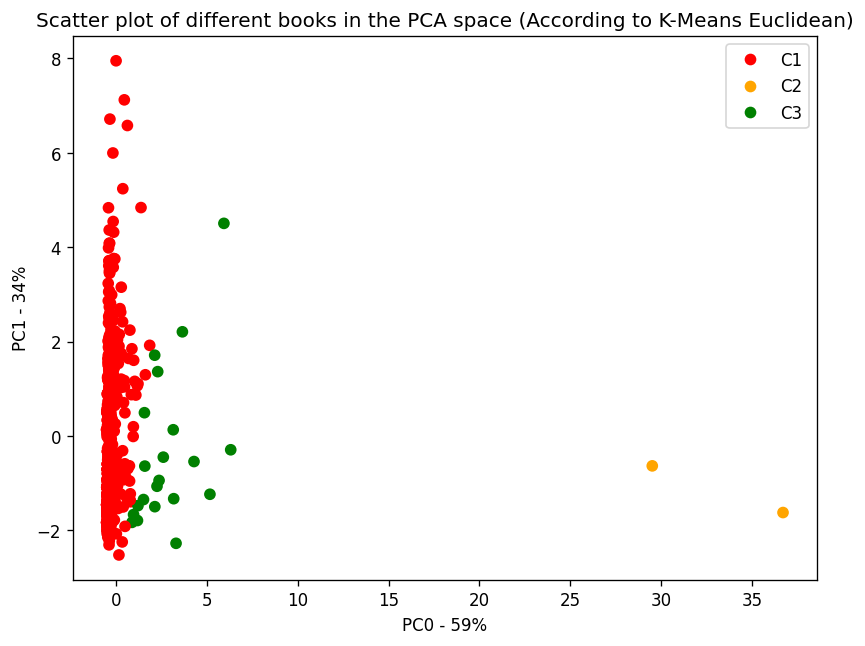

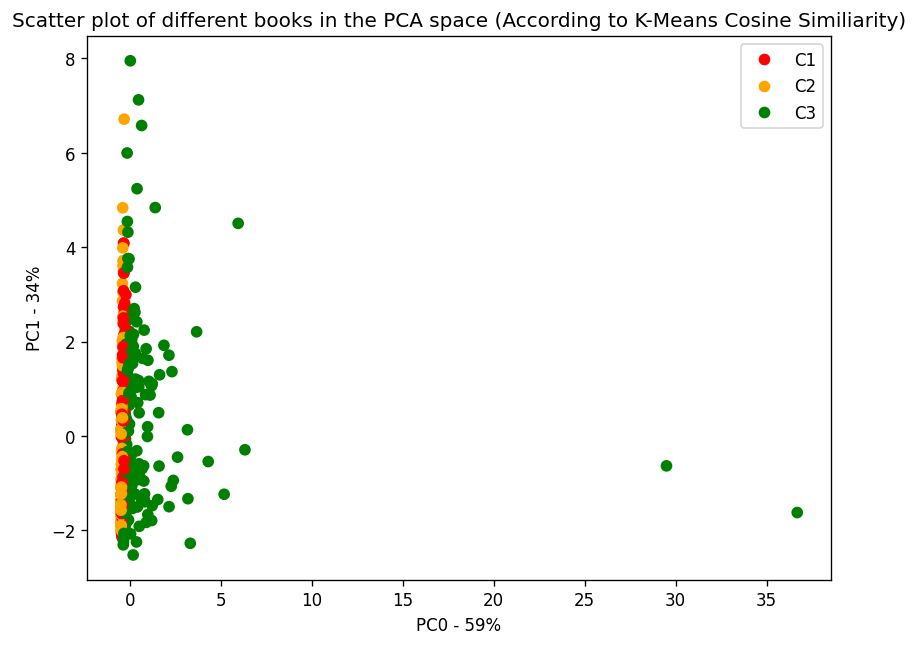

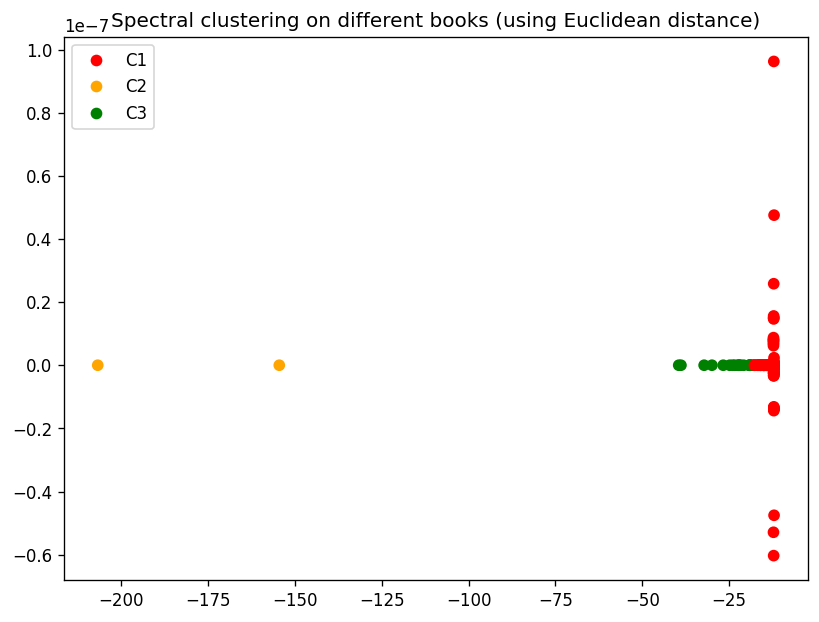

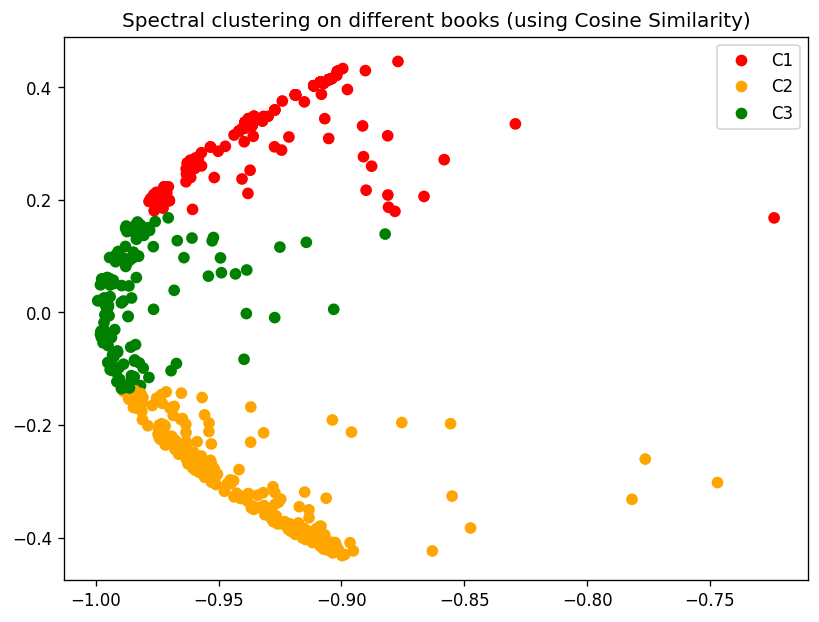

,Silhouet (Euclidean),Mut. Info. (Euclidean),Silhouet (Cosine),Mut. Info. (Cosine)
K-means,0.875827,-0.001078,0.515563,0.002962
Spectral,0.924439,-0.002713,0.768060,0.002962


Batch Number 3 Of Book Samples
⭐ : 17 samples
⭐⭐ : 11 samples
⭐⭐⭐ : 500 samples


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,Class
0007491727,5.0,3.000000,3.697290,3.0,0.894427,2.0,1.0,2.0,0.0
006019796X,7.0,2.857143,3.526248,2.0,1.019804,4.0,1.0,2.0,0.0
0028642600,5.0,1.800000,3.197290,2.0,0.894427,4.0,1.0,0.0,0.0
0060281766,6.0,2.000000,3.182114,2.0,0.979796,4.0,1.0,1.0,0.0
0060197935,14.0,2.928571,3.350832,3.0,0.400000,6.0,3.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...
0020360754,16.0,4.500000,4.407282,5.0,3.867816,1.0,0.0,15.0,2.0
0007391595,79.0,4.240506,4.236831,4.0,14.260435,2.0,16.0,61.0,2.0
0060197463,5.0,4.200000,4.197290,4.0,1.549193,0.0,0.0,5.0,2.0
0060514094,24.0,4.416667,4.366693,5.0,5.741080,2.0,2.0,20.0,2.0


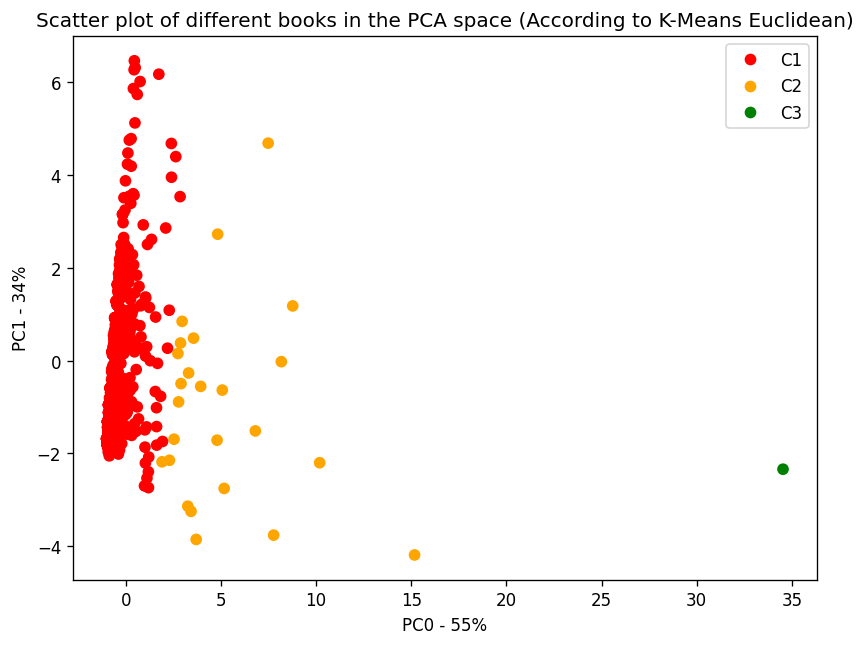

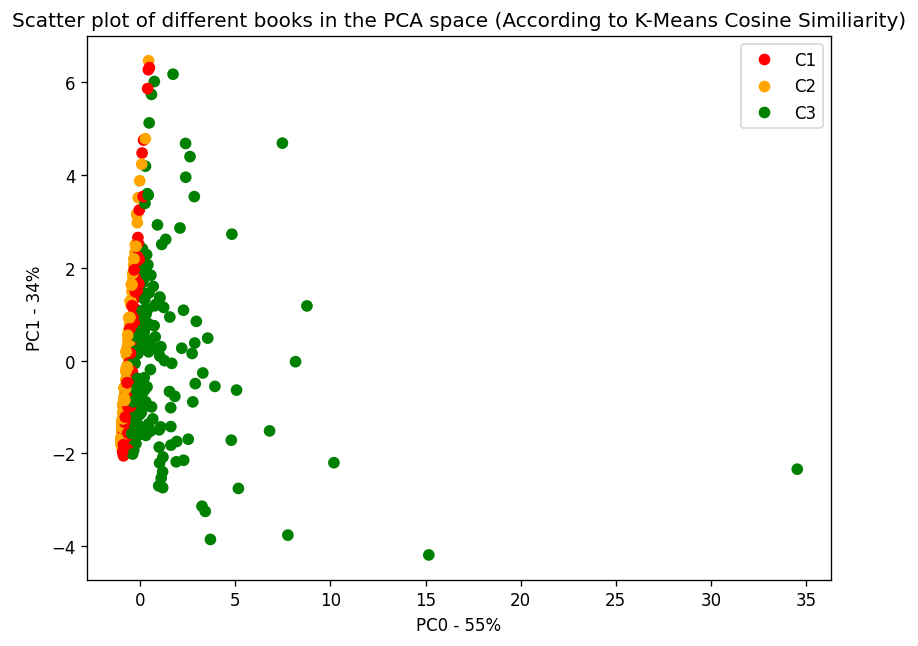

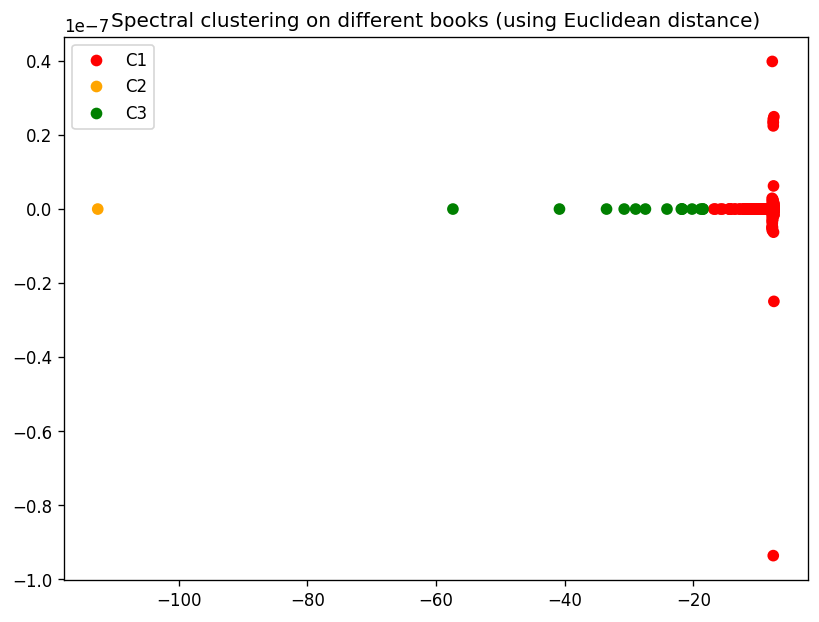

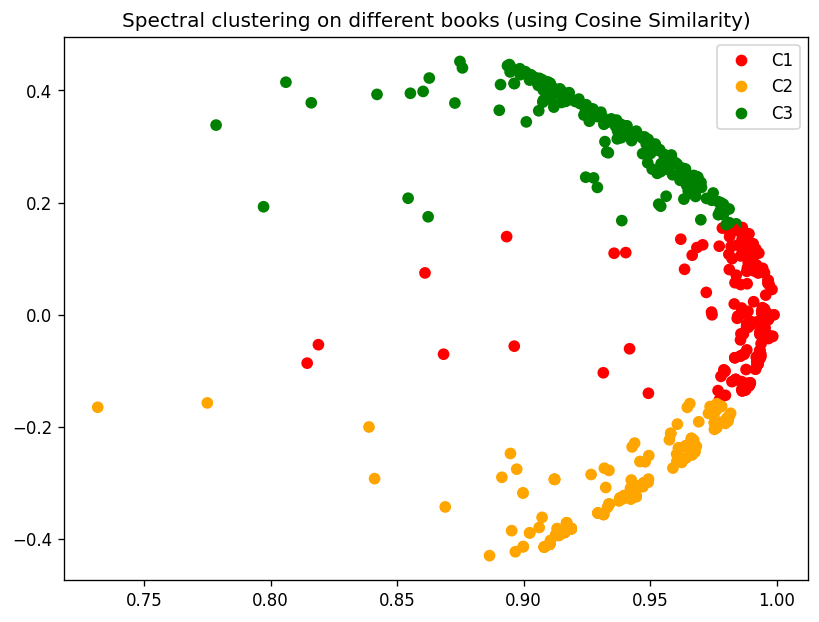

,Silhouet (Euclidean),Mut. Info. (Euclidean),Silhouet (Cosine),Mut. Info. (Cosine)
K-means,0.860453,-0.006239,0.517137,0.013201
Spectral,0.930467,-0.005774,0.778226,0.013344


Batch Number 4 Of Book Samples
⭐ : 17 samples
⭐⭐ : 11 samples
⭐⭐⭐ : 500 samples


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,Class
006000181X,9.0,2.777778,3.397967,2.0,1.166190,5.0,1.0,3.0,0.0
0006514359,45.0,2.622222,2.833990,2.0,4.147288,27.0,5.0,13.0,0.0
0060007443,9.0,3.000000,3.522967,2.0,1.326650,5.0,0.0,4.0,0.0
0007175337,14.0,3.214286,3.541308,3.0,1.469694,6.0,2.0,6.0,0.0
006000455X,14.0,1.214286,2.207975,1.0,4.261455,14.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
0060001534,28.0,4.642857,4.553357,5.0,7.525955,0.0,2.0,26.0,2.0
0007223706,15.0,4.000000,4.062158,4.0,2.683282,0.0,4.0,11.0,2.0
0007179030,5.0,4.400000,4.280623,5.0,1.095445,0.0,1.0,4.0,2.0
0006158048,26.0,3.961538,4.011136,4.0,3.709447,4.0,3.0,19.0,2.0


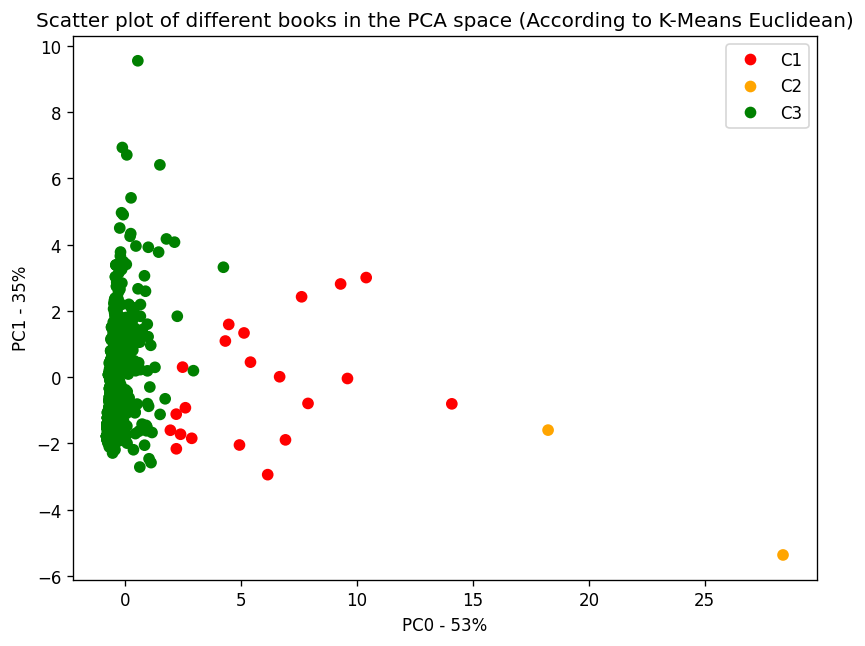

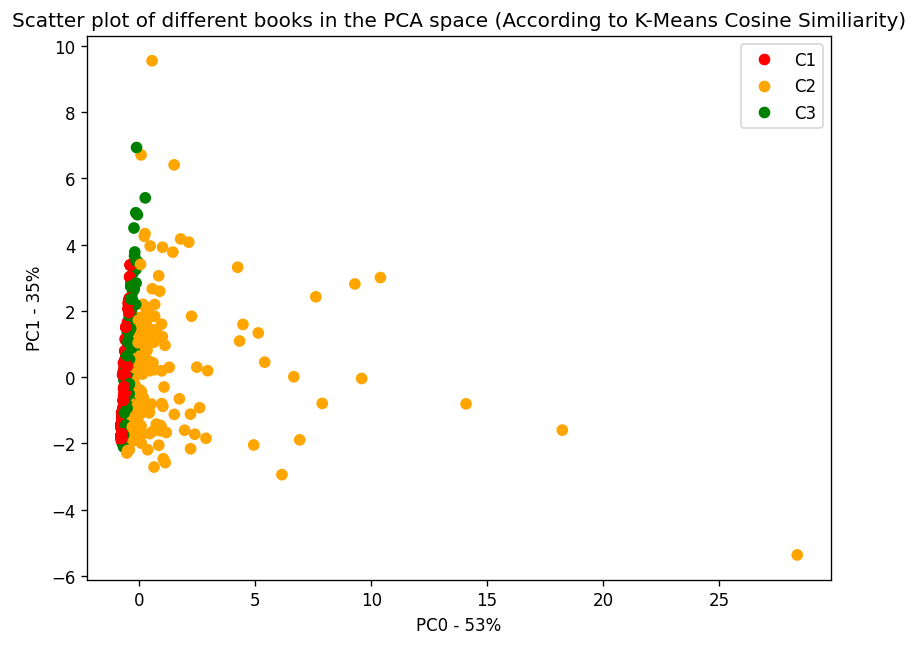

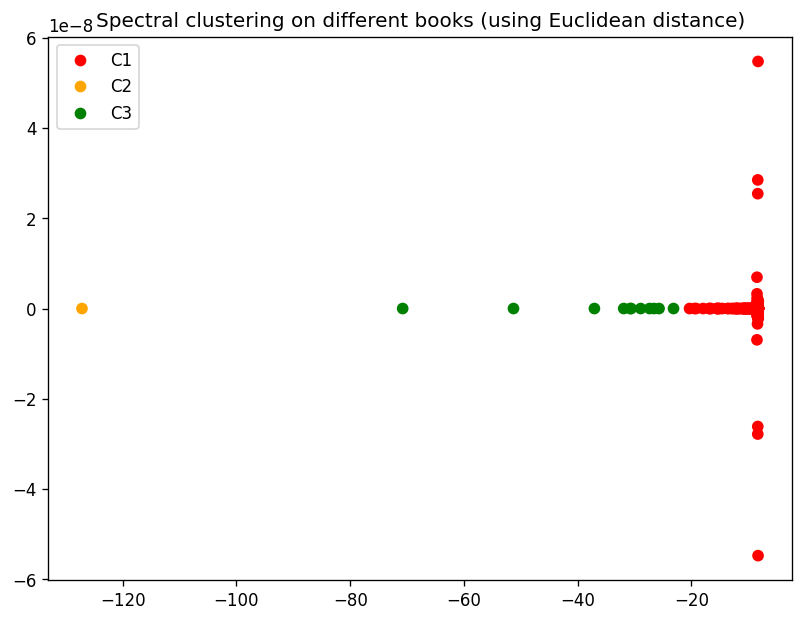

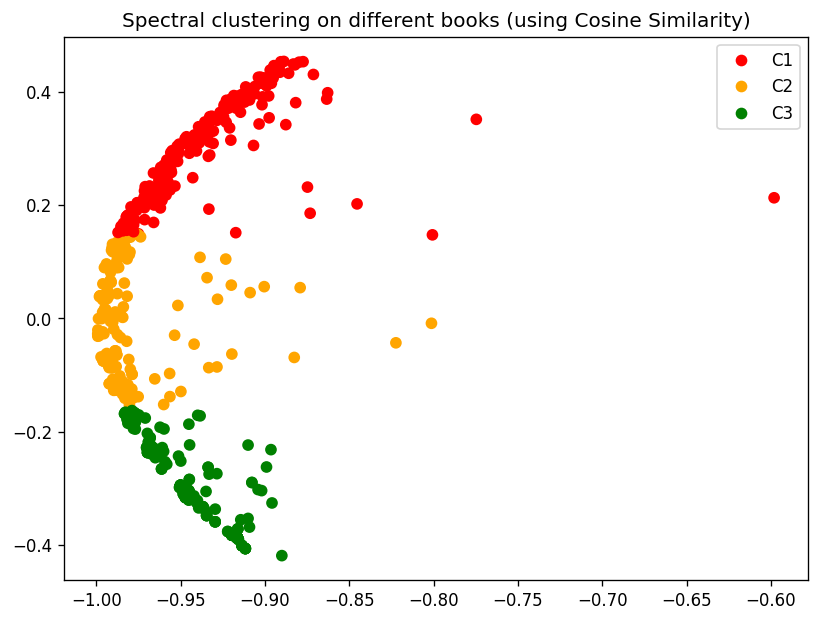

,Silhouet (Euclidean),Mut. Info. (Euclidean),Silhouet (Cosine),Mut. Info. (Cosine)
K-means,0.890884,-0.001078,0.504249,0.012373
Spectral,0.949020,-0.004676,0.768392,0.007559


Batch Number 5 Of Book Samples
⭐ : 17 samples
⭐⭐ : 11 samples
⭐⭐⭐ : 500 samples


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,Class
006050594X,5.0,3.000000,3.697290,2.0,1.095445,3.0,0.0,2.0,0.0
006050353X,6.0,2.500000,3.412883,3.0,0.748331,3.0,1.0,2.0,0.0
0028636597,8.0,2.500000,3.291165,1.0,2.059126,5.0,0.0,3.0,0.0
0060524073,35.0,2.371429,2.675416,2.0,4.195235,24.0,3.0,8.0,0.0
006000181X,9.0,2.777778,3.397967,2.0,1.166190,5.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...
0060392320,24.0,3.875000,3.947338,4.0,3.059412,4.0,4.0,16.0,2.0
0060008032,65.0,3.692308,3.741215,4.0,7.071068,11.0,12.0,42.0,2.0
0060085444,37.0,3.783784,3.849261,4.0,4.223742,6.0,7.0,24.0,2.0
0007514913,28.0,4.714286,4.610499,5.0,8.014986,0.0,1.0,27.0,2.0


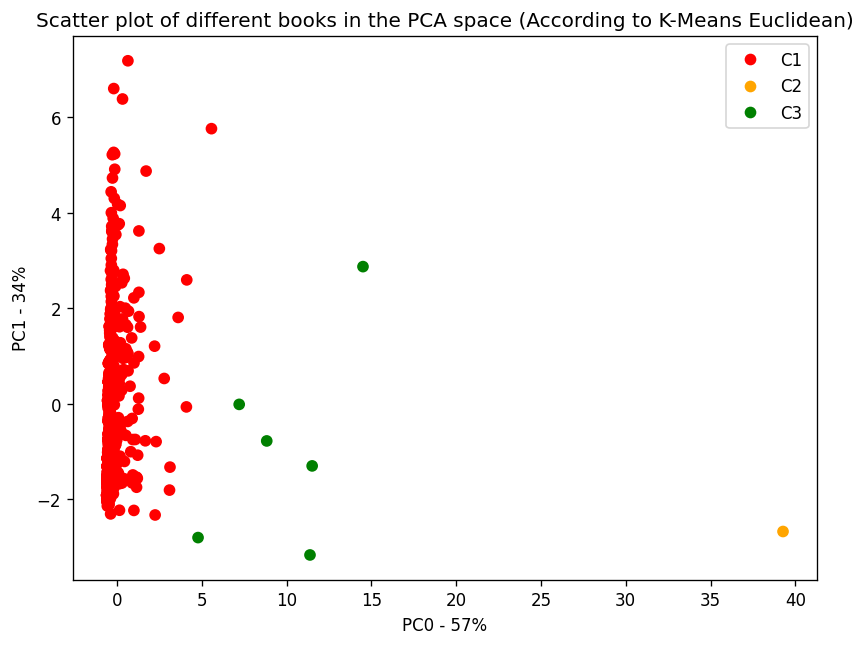

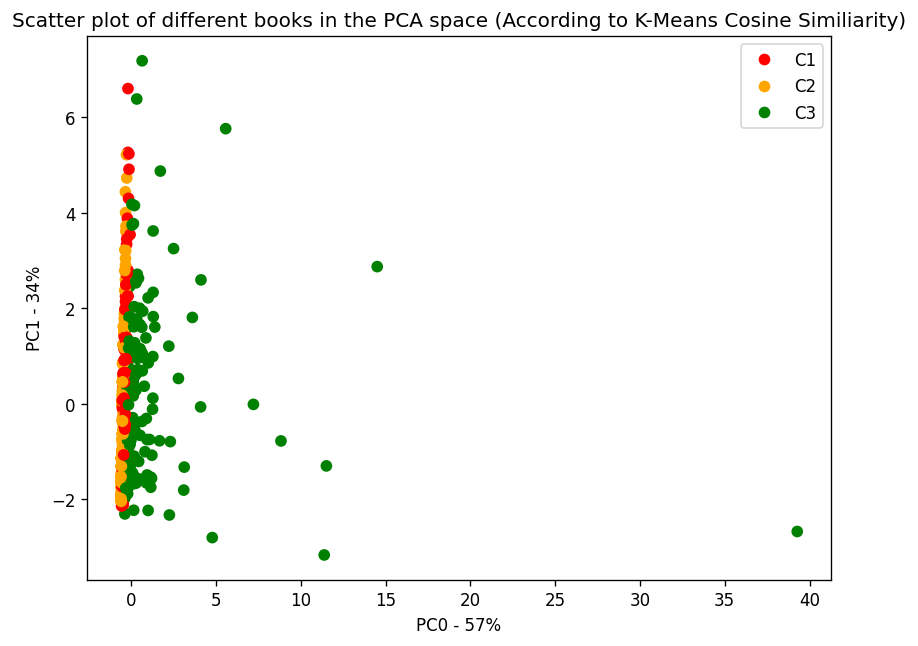

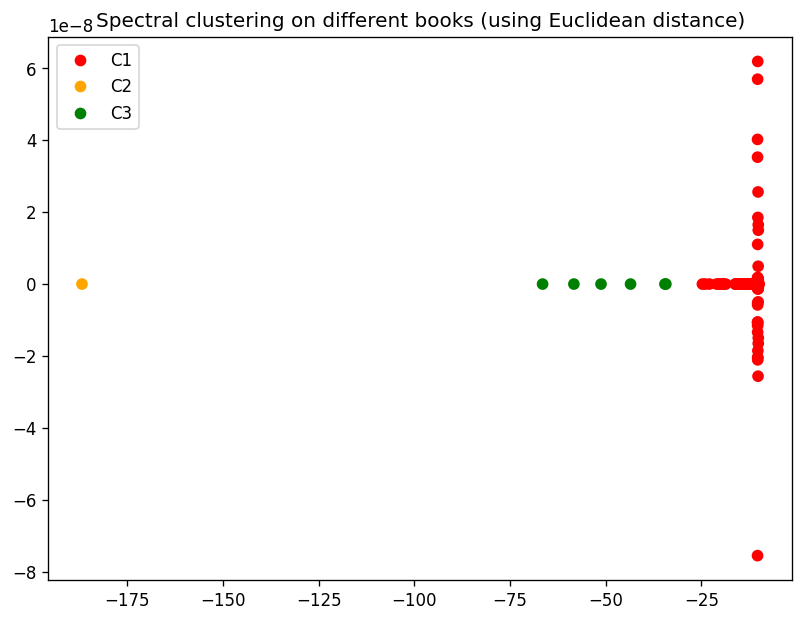

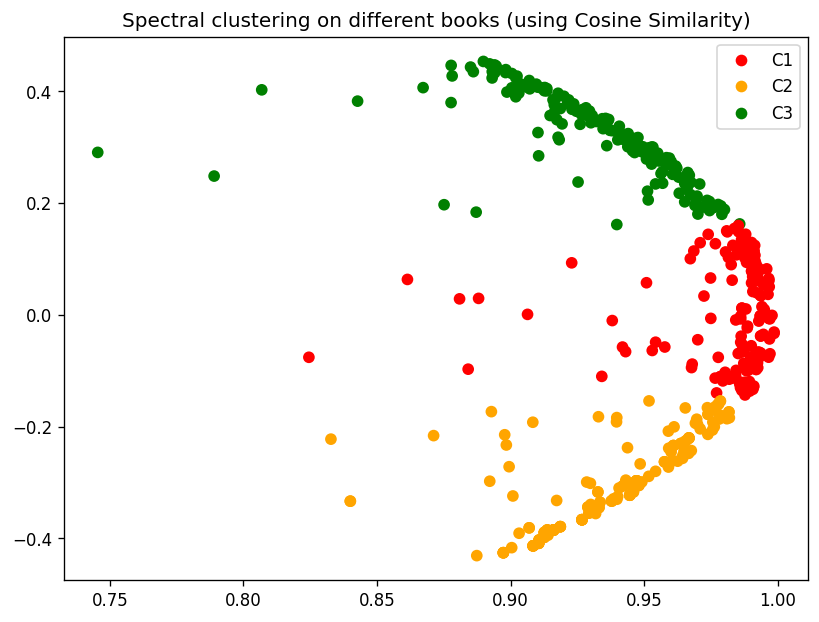

,Silhouet (Euclidean),Mut. Info. (Euclidean),Silhouet (Cosine),Mut. Info. (Cosine)
K-means,0.942561,-0.006074,0.514991,0.000239
Spectral,0.964269,-0.006074,0.770855,0.000344


In [141]:
# Q B-3
def fullAnalysis(pdBooksFeatures, booksFeatures):
    kmeansEucli, kmeansCos = displayKmeansClustering(pdBooksFeatures, pdBooksFeatures)
    spectralEucliCoords, spectralEucli, spectralCosCoords, spectralCos = displaySpectralClustering(pdBooksFeatures)
    displayAccuracyMatrix(
        pdBooksFeatures, 
        booksFeatures, 
        (kmeansEucli, kmeansCos), 
        (spectralEucli, spectralCos), 
        spectralEucliCoords, 
        spectralCosCoords
    )


X = []
for i in range(0,5):
    print(f"Batch Number {i+1} Of Book Samples")
    # https://www.geeksforgeeks.org/stratified-sampling-in-pandas/
    X.append(pdBooksFeatures.groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=0.2)))
    count = [ (X[-1].Class.values == i).sum() for i in range(0, 3) ]
    for i in range(0,3):
        nbStars = (i+1) * "⭐"
        print(f"{nbStars} : {count[i]} samples")
    display(X[-1])
    fullAnalysis(X[-1], X[-1][CRITERIAS])